In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import sys
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import entropy
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

from utils import plot_clusters, get_cluster_pos

## Roadmap

1. Visualize each layer of the calorimeter
2. For a given layer, and for an event with two clear clusters, visualize the clusters
3. Run DBSCAN on the clusters
4. Visualize the cluster labels
5. Visualize the energy-weighted cluster centers
6. Match clusters across layers with a simple line fit (# of lines = average # of clusters per layer)
7. Visualize the line fit
8. Define a simple metric for cluster matching (e.g. scikit learn completeness)

## 1. Load Event and Visualize

In [2]:
sys.path.insert(0, '..')

from eventContainer import eventContainer
from exampleMLBasedCluster import exampleMLBasedCluster

In [3]:
file_path = "/global/cfs/cdirs/m3443/data/PowerWeek/merged_tree_Hannahchanges_20230616.root"
file1 = uproot.open(file_path)
tree1 = file1['event_tree']
branches1 = tree1.arrays()

In [4]:
testev = eventContainer(60, branches1)

In [5]:
testev

---- Event #60 ----
Number of hits: 571
Number of unique particles: 2
Total energy: 62.24720001220703

In [6]:
testev = testev.to_pandas()

In [7]:
testev.head()

,E,ix,iy,iz,posx,posy,posz,NContributions,trueID1,trueID2,trueID3,trueID4,trueEfrac1,trueEfrac2,trueEfrac3,trueEfrac4
0,5.695240,51,44,1,-47.370159,-52.575001,387.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0
1,4.244005,51,44,2,-47.370159,-52.575001,397.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0
2,4.063787,51,45,2,-47.370159,-57.424999,393.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0
3,2.730911,44,45,2,-52.629841,-57.424999,405.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0
4,2.306139,50,44,1,-42.456718,-52.575001,377.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0


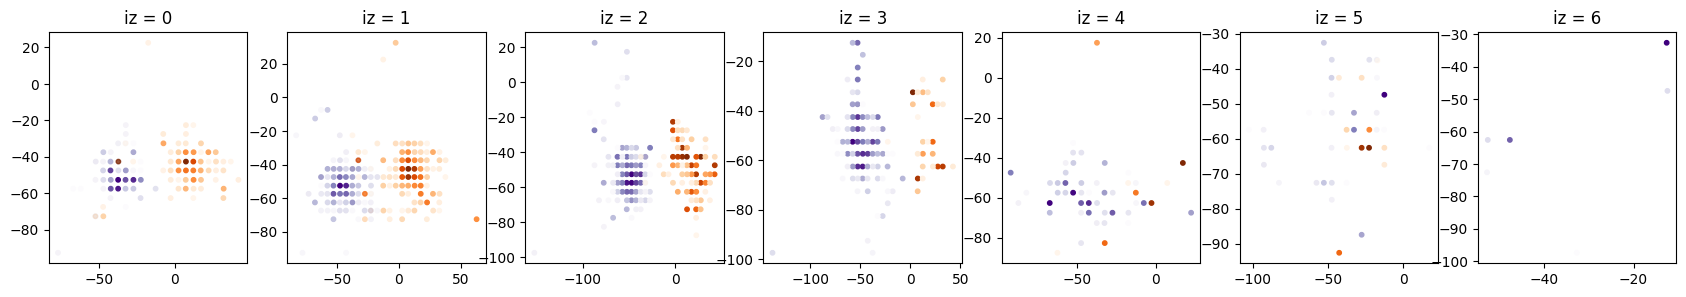

In [8]:
fig, axs = plt.subplots(1, len(testev.iz.unique()), figsize=(3*len(testev.iz.unique()), 3))

for i, iz in enumerate(sorted(testev.iz.unique())):
    ids = [1, 2]
    colors = ['Purples', 'Oranges']
    for id in ids:
       for pid in [0, 1]:
            if sum(testev[testev.iz == iz][f'trueID{id}'] == pid) > 0:
                axs[i].scatter(testev[testev.iz == iz].posx[testev[testev.iz == iz][f'trueID{id}'] == pid], testev[testev.iz == iz].posy[testev[testev.iz == iz][f'trueID{id}'] == pid], label=f'Particle {pid}', c=np.log(testev[testev.iz == iz].E[testev[testev.iz == iz][f'trueID{id}'] == pid]), cmap=colors[pid], alpha=testev[testev.iz == iz][f'trueEfrac{id}'][testev[testev.iz == iz][f'trueID{id}'] == pid], s=10)

    axs[i].set_title(f'iz = {iz}')

## 2. Visualize Layer 0

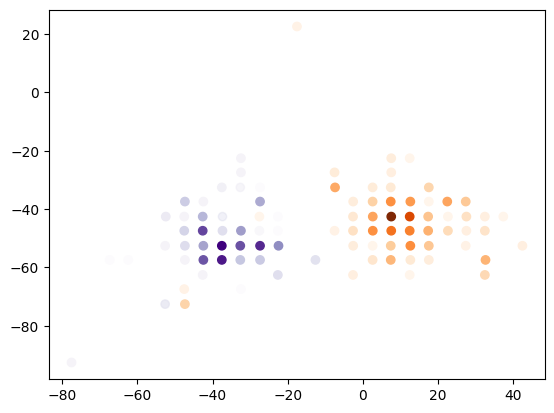

In [9]:
z0_layer = testev[testev.iz == 0]
plt.scatter(z0_layer.posx[z0_layer.trueID1 == 0], z0_layer.posy[z0_layer.trueID1 == 0], label='Particle0', c=np.log(z0_layer.E[z0_layer.trueID1 == 0]), cmap='Purples', alpha=z0_layer.trueEfrac1[z0_layer.trueID1 == 0])
plt.scatter(z0_layer.posx[z0_layer.trueID1 == 1], z0_layer.posy[z0_layer.trueID1 == 1], label='Particle1', c=np.log(z0_layer.E[z0_layer.trueID1 == 1]), cmap='Oranges', alpha=z0_layer.trueEfrac1[z0_layer.trueID1 == 1])

## 3. DBSCAN on Layer 0

Vanilla DBSCAN

In [10]:
def dbscan_cluster(df, eps=11., min_samples=3):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(df[['posx', 'posy']])
    df.loc[:, 'dbscan_label'] = dbscan.labels_
    return df

In [11]:
# DBSCAN
dbscan = DBSCAN(eps=11., min_samples=3)
dbscan.fit(z0_layer[['posx', 'posy']])
# z0_layer['dbscan_label'] = dbscan.labels_
z0_layer.loc[:, 'dbscan_label'] = dbscan.labels_
print(z0_layer.dbscan_label.unique())

[ 0 -1  1]


/tmp/ipykernel_1271172/4248540118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z0_layer.loc[:, 'dbscan_label'] = dbscan.labels_


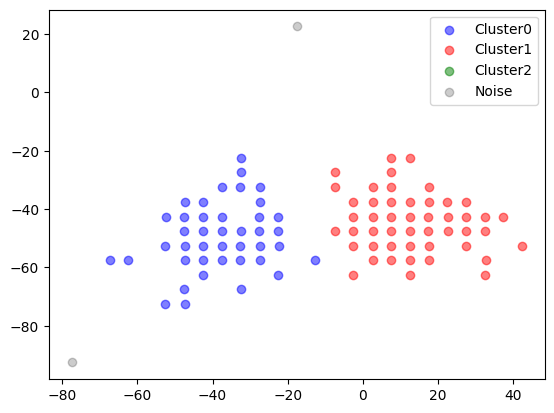

In [12]:
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 0], z0_layer.posy[z0_layer.dbscan_label == 0], label='Cluster0', c='blue', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 1], z0_layer.posy[z0_layer.dbscan_label == 1], label='Cluster1', c='red', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 2], z0_layer.posy[z0_layer.dbscan_label == 2], label='Cluster2', c='green', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == -1], z0_layer.posy[z0_layer.dbscan_label == -1], label='Noise', c='black', alpha=0.2)
plt.legend()

Sample weighted DBSCAN

In [13]:
# DBSCAN
dbscan = DBSCAN(eps=15, min_samples=1)
dbscan.fit(z0_layer[['posx', 'posy']], sample_weight=z0_layer.E)
# z0_layer['dbscan_label'] = dbscan.labels_
z0_layer.loc[:, 'dbscan_label'] = dbscan.labels_
print(z0_layer.dbscan_label.unique())

[ 0 -1  1]


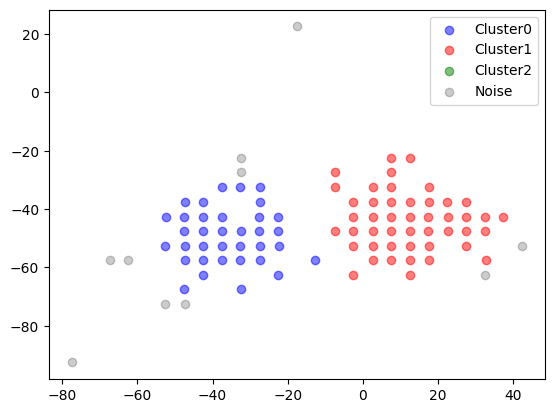

In [14]:
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 0], z0_layer.posy[z0_layer.dbscan_label == 0], label='Cluster0', c='blue', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 1], z0_layer.posy[z0_layer.dbscan_label == 1], label='Cluster1', c='red', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 2], z0_layer.posy[z0_layer.dbscan_label == 2], label='Cluster2', c='green', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == -1], z0_layer.posy[z0_layer.dbscan_label == -1], label='Noise', c='black', alpha=0.2)
plt.legend()

In [17]:
cluster_0_posx, cluster_0_posy, cluster_0_posz, cluster_0_posx_std, cluster_0_posy_std, cluster_0_posz_std = get_cluster_pos(z0_layer, 0)
cluster_1_posx, cluster_1_posy, cluster_1_posz, cluster_1_posx_std, cluster_1_posy_std, cluster_1_posz_std = get_cluster_pos(z0_layer, 1)

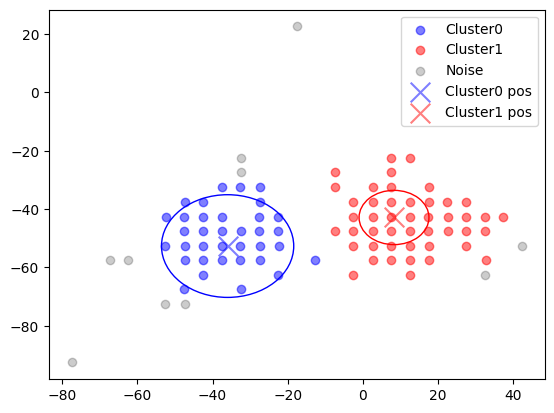

In [166]:
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 0], z0_layer.posy[z0_layer.dbscan_label == 0], label='Cluster0', c='blue', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 1], z0_layer.posy[z0_layer.dbscan_label == 1], label='Cluster1', c='red', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == -1], z0_layer.posy[z0_layer.dbscan_label == -1], label='Noise', c='black', alpha=0.2)
plt.scatter(cluster_0_posx, cluster_0_posy, label='Cluster0 pos', c='blue', alpha=0.5, s=200, marker='x')
plt.scatter(cluster_1_posx, cluster_1_posy, label='Cluster1 pos', c='red', alpha=0.5, s=200, marker='x')

# Add a circle to show the std dev of each cluster
circle = plt.Circle((cluster_0_posx, cluster_0_posy), 3*cluster_0_posx_std, color='blue', fill=False)
plt.gcf().gca().add_artist(circle)
circle = plt.Circle((cluster_1_posx, cluster_1_posy), 3*cluster_1_posx_std, color='red', fill=False)
plt.gcf().gca().add_artist(circle)

plt.legend()

/tmp/ipykernel_1537930/2884814132.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(layer.dbscan_label.unique()))
/tmp/ipykernel_1537930/2884814132.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_posx, cluster_posy, label=f'Cluster{label} pos', alpha=0.5, s=200, marker='x', c=cmap(i))


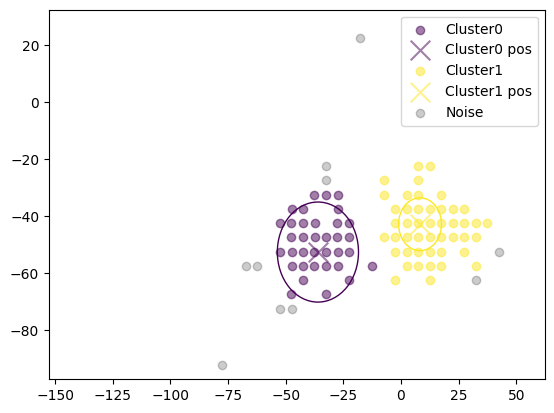

In [168]:
plot_clusters(z0_layer, x_bounds=(testev.posx.min(), testev.posx.max()), y_bounds=(testev.posy.min(), testev.posy.max()))

HDBSCAN

In [16]:
# HDBSCAN
dbscan = HDBSCAN(min_cluster_size=10)
dbscan.fit(z0_layer[['posx', 'posy']])
# z0_layer['dbscan_label'] = dbscan.labels_
z0_layer.loc[:, 'dbscan_label'] = dbscan.labels_
print(z0_layer.dbscan_label.unique())

[ 0 -1  1]


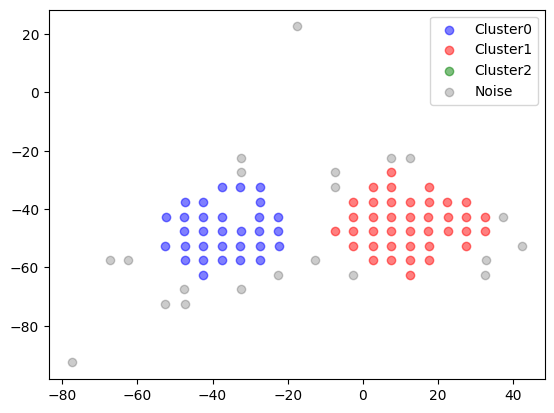

In [17]:
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 0], z0_layer.posy[z0_layer.dbscan_label == 0], label='Cluster0', c='blue', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 1], z0_layer.posy[z0_layer.dbscan_label == 1], label='Cluster1', c='red', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == 2], z0_layer.posy[z0_layer.dbscan_label == 2], label='Cluster2', c='green', alpha=0.5)
plt.scatter(z0_layer.posx[z0_layer.dbscan_label == -1], z0_layer.posy[z0_layer.dbscan_label == -1], label='Noise', c='black', alpha=0.2)
plt.legend()

KMeans

## 5. Energy Weighted Cluster Centers

In [15]:
# DBSCAN
dbscan = DBSCAN(eps=15, min_samples=1)
dbscan.fit(z0_layer[['posx', 'posy']], sample_weight=z0_layer.E)
# z0_layer['dbscan_label'] = dbscan.labels_
z0_layer.loc[:, 'dbscan_label'] = dbscan.labels_
print(z0_layer.dbscan_label.unique())

[ 0 -1  1]


/global/u2/d/danieltm/Side_Work/PowerWeek/ePIC_Clustering_2023/examples/utils.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_posx, cluster_posy, label=f'Cluster{label} pos', alpha=0.5, s=200, marker='x', c=cmap(i))


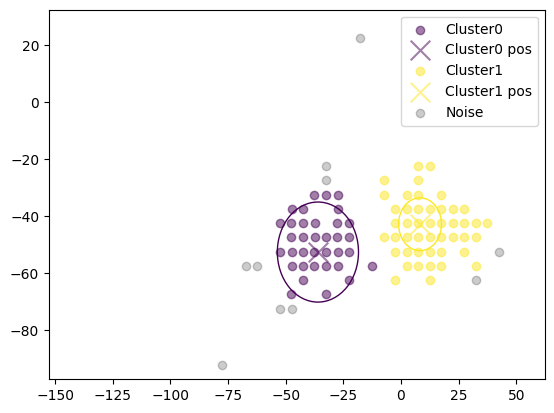

In [16]:
plot_clusters(z0_layer, x_bounds=(testev.posx.min(), testev.posx.max()), y_bounds=(testev.posy.min(), testev.posy.max()))

## 6. Match Clusters Across Layers

In [17]:
%%time
# Run clustering across each layer
# testev.loc[:, 'norm_log_E'] = (np.log(testev.E) - np.min(np.log(testev.E))) / (np.max(np.log(testev.E)) - np.min(np.log(testev.E)))
cluster_layers = []
for i, iz in enumerate(sorted(testev.iz.unique())):
    layer = testev[testev.iz == iz]
    dbscan = DBSCAN(eps=15, min_samples=1)
    dbscan.fit(layer[['posx', 'posy']], sample_weight=layer.E)
    layer.loc[:, 'dbscan_label'] = dbscan.labels_
    print(layer.dbscan_label.unique())
    cluster_layers.append(layer)

<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1]
[-1]
[-1]
[-1]
CPU times: user 2.05 s, sys: 1.9 ms, total: 2.05 s
Wall time: 292 ms


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/global/u2/d/danieltm/Side_Work/PowerWeek/ePIC_Clustering_2023/examples/utils.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_posx, cluster_posy, label=f'Cluster{label} pos', alpha=0.5, s=200, marker='x', c=cmap(i))


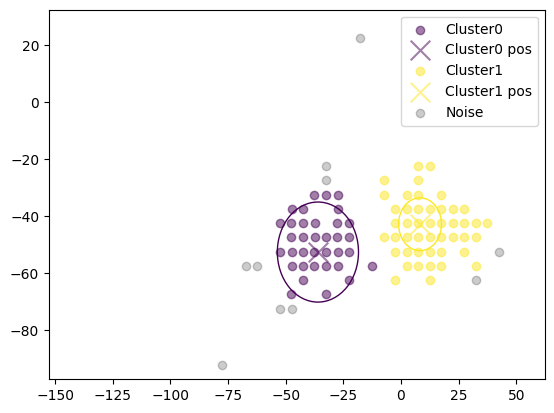

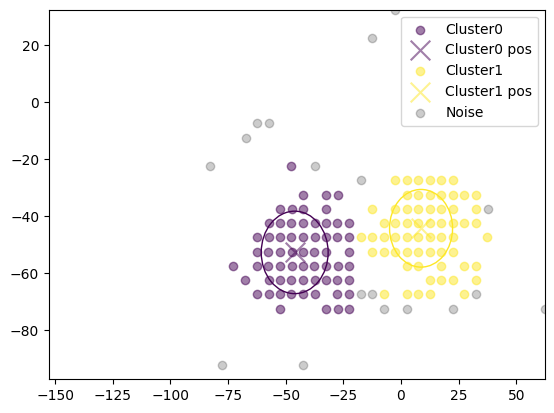

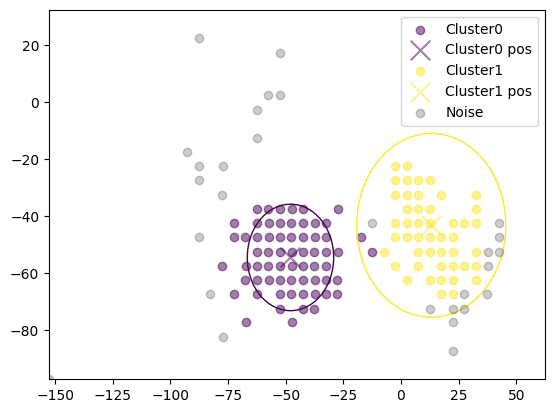

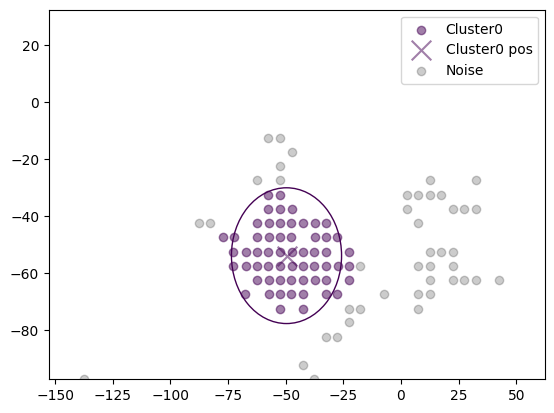

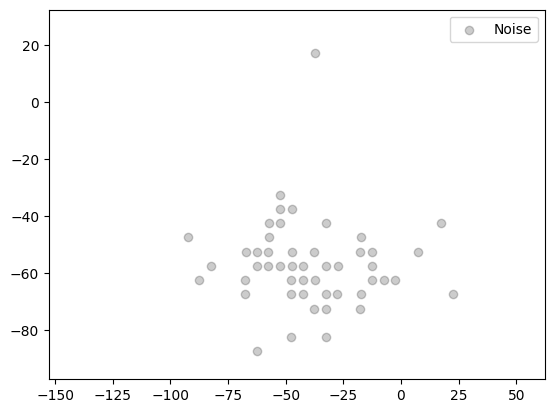

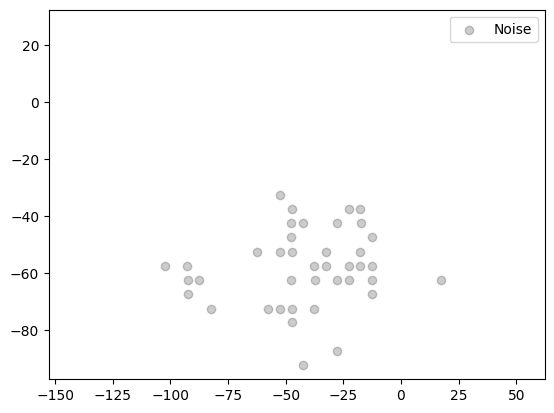

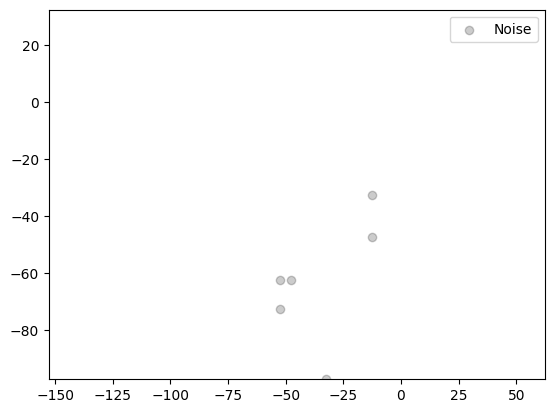

In [18]:
x_bounds, y_bounds =(testev.posx.min(), testev.posx.max()), (testev.posy.min(), testev.posy.max())

for layer in cluster_layers:
    plot_clusters(layer, x_bounds=x_bounds, y_bounds=y_bounds)
    plt.show()

In [19]:
# Make list of cluster positions
cluster_pos_list = []
for layer in cluster_layers:
    for label in layer.dbscan_label.unique():
        if label == -1:
            continue
        cluster_pos = get_cluster_pos(layer, label)
        cluster_layer = layer.iz.unique()[0]
        cluster_pos_list.append((cluster_pos[0], cluster_pos[1], cluster_pos[2], cluster_pos[3], cluster_pos[4], cluster_pos[5], cluster_layer, label))
        

# Convert to pandas
cluster_pos_df = pd.DataFrame(cluster_pos_list, columns=['posx', 'posy', 'posz', 'posx_std', 'posy_std', 'posz_std', 'layer', 'in_layer_label'])

In [20]:
cluster_pos_df

,posx,posy,posz,posx_std,posy_std,posz_std,layer,in_layer_label
0,-36.003151,-52.676819,366.388092,5.865685,4.554435,1.858126,0,0
1,8.282622,-42.885265,367.331879,3.100558,2.403930,0.663582,0,1
2,-46.075157,-52.799324,384.361847,4.835243,3.759557,4.471521,1,0
3,8.726524,-44.314201,376.341675,4.553845,4.671607,5.785995,1,1
4,-47.898113,-54.574562,399.031219,6.241280,5.095376,5.196375,2,0
5,13.150117,-43.295731,398.747803,10.775564,9.136436,5.278163,2,1
6,-49.625412,-53.946728,415.223969,7.958901,6.915788,4.622452,3,0


In [21]:
# Make 2d array from x, y
cluster_pos_array = np.array(cluster_pos_df[['posx', 'posy']])

## Simple X-Y overlap

In [22]:
cluster_pos_array

array([[-36.00315 , -52.67682 ],
       [  8.282622, -42.885265],
       [-46.075157, -52.799324],
       [  8.726524, -44.3142  ],
       [-47.898113, -54.574562],
       [ 13.150117, -43.29573 ],
       [-49.625412, -53.946728]], dtype=float32)

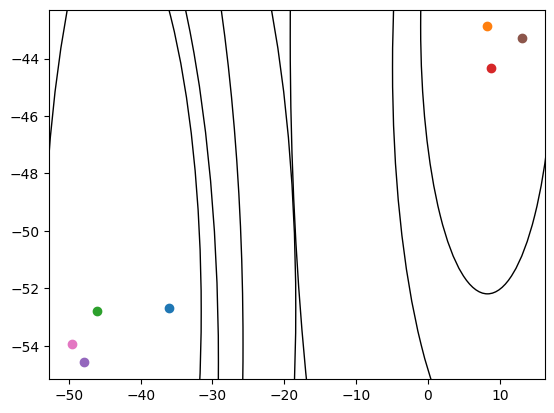

In [23]:
# Plot all clusters and cluster circles in x, y
for cluster_pos in cluster_pos_list:
    plt.scatter(cluster_pos[0], cluster_pos[1])
    circle = plt.Circle((cluster_pos[0], cluster_pos[1]), 3*cluster_pos[3], fill=False)
    plt.gcf().gca().add_artist(circle)

In [24]:
# DBSCAN on cluster positions
dbscan = DBSCAN(eps=20, min_samples=1)
dbscan.fit(cluster_pos_array)
cluster_pos_df.loc[:, 'multicluster_label'] = dbscan.labels_
print(cluster_pos_df.multicluster_label.unique())

[0 1]


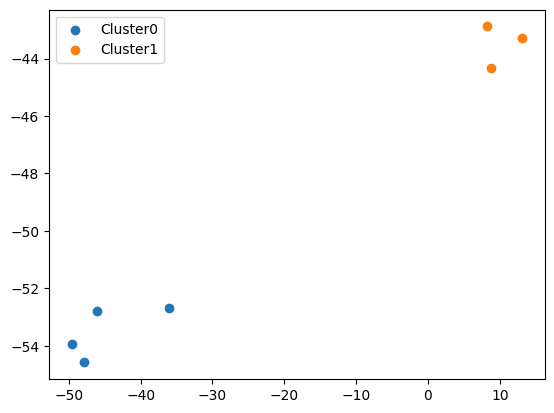

In [25]:
# Plot clusters
for label in cluster_pos_df.multicluster_label.unique():
    if label == -1:
        continue
    cluster_pos = cluster_pos_df[cluster_pos_df.multicluster_label == label]
    plt.scatter(cluster_pos.posx, cluster_pos.posy, label=f'Cluster{label}')

plt.legend()

## 7. Create Cluster Objects from Matched Clusters

In [26]:
cluster_pos_df

,posx,posy,posz,posx_std,posy_std,posz_std,layer,in_layer_label,multicluster_label
0,-36.003151,-52.676819,366.388092,5.865685,4.554435,1.858126,0,0,0
1,8.282622,-42.885265,367.331879,3.100558,2.403930,0.663582,0,1,1
2,-46.075157,-52.799324,384.361847,4.835243,3.759557,4.471521,1,0,0
3,8.726524,-44.314201,376.341675,4.553845,4.671607,5.785995,1,1,1
4,-47.898113,-54.574562,399.031219,6.241280,5.095376,5.196375,2,0,0
5,13.150117,-43.295731,398.747803,10.775564,9.136436,5.278163,2,1,1
6,-49.625412,-53.946728,415.223969,7.958901,6.915788,4.622452,3,0,0


In [27]:
cluster_layers[0]

,E,ix,iy,iz,posx,posy,posz,NContributions,trueID1,trueID2,trueID3,trueID4,trueEfrac1,trueEfrac2,trueEfrac3,trueEfrac4,dbscan_label
15,0.393842,49,44,0,-37.543282,-52.575001,365.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0
26,0.253213,49,45,0,-37.543282,-57.424999,365.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0
37,0.192591,55,44,0,-27.370159,-52.575001,369.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0
45,0.120833,46,47,0,-42.629841,-47.424999,367.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0
49,0.098564,48,44,0,-32.629841,-52.575001,369.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,0.001650,51,46,0,-27.543280,-42.575001,367.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,0
559,0.001650,59,44,0,2.586560,-52.575001,369.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1
563,0.001650,62,49,0,17.543280,-37.424999,367.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1
565,0.001650,59,42,0,12.456720,-62.575001,363.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1


In [28]:
# Need to get all hits in each cluster of clusters
multi_depth_clusters = []
for label in cluster_pos_df.multicluster_label.unique():
    if label == -1:
        continue
    multicluster_df = cluster_pos_df[cluster_pos_df.multicluster_label == label]
    break

In [29]:
multicluster_df

,posx,posy,posz,posx_std,posy_std,posz_std,layer,in_layer_label,multicluster_label
0,-36.003151,-52.676819,366.388092,5.865685,4.554435,1.858126,0,0,0
2,-46.075157,-52.799324,384.361847,4.835243,3.759557,4.471521,1,0,0
4,-47.898113,-54.574562,399.031219,6.241280,5.095376,5.196375,2,0,0
6,-49.625412,-53.946728,415.223969,7.958901,6.915788,4.622452,3,0,0


In [30]:
# Need to get all hits in each cluster of clusters
multi_depth_clusters = []
for label in cluster_pos_df.multicluster_label.unique():
    if label == -1:
        continue
    multicluster_df = cluster_pos_df[cluster_pos_df.multicluster_label == label]
    multicluster = []
    for i, layer in enumerate(cluster_layers):
        multicluster.append(layer[layer.dbscan_label.isin(multicluster_df.in_layer_label.unique())])
    # concat
    multicluster = pd.concat(multicluster)
    # add pred_label column
    multicluster.loc[:, 'pred_label'] = label
    multi_depth_clusters.append(multicluster)

multi_depth_clusters


[            E  ix  iy  iz       posx       posy        posz  NContributions  \
 15   0.393842  49  44   0 -37.543282 -52.575001  365.279999               1   
 26   0.253213  49  45   0 -37.543282 -57.424999  365.279999               1   
 37   0.192591  55  44   0 -27.370159 -52.575001  369.279999               1   
 45   0.120833  46  47   0 -42.629841 -47.424999  367.279999               1   
 49   0.098564  48  44   0 -32.629841 -52.575001  369.279999               1   
 ..        ...  ..  ..  ..        ...        ...         ...             ...   
 317  0.001650  51  49   3 -47.370159 -37.424999  413.279968               1   
 325  0.001650  47  45   3 -67.370163 -57.424999  411.279968               1   
 330  0.001650  40  44   3 -72.629837 -52.575001  417.279968               1   
 331  0.001650  54  45   3 -22.456720 -57.424999  413.279968               1   
 567  0.001650  54  44   3 -22.456720 -52.575001  413.279968               1   
 
      trueID1  trueID2  trueID3  trueI

In [31]:
multi_depth_clusters[1]

,E,ix,iy,iz,posx,posy,posz,NContributions,trueID1,trueID2,trueID3,trueID4,trueEfrac1,trueEfrac2,trueEfrac3,trueEfrac4,dbscan_label,pred_label
338,8.995675,60,46,0,7.543280,-42.575001,367.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1
342,0.985223,59,46,0,12.456720,-42.575001,367.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1
349,0.265585,60,47,0,7.543280,-47.424999,369.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1
352,0.171146,59,47,0,12.456720,-47.424999,367.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1
362,0.118771,63,44,0,12.629840,-52.575001,367.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,0.002062,57,44,2,-7.413440,-52.575001,393.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1
536,0.002062,58,45,2,7.413440,-57.424999,393.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1
538,0.002062,63,42,2,32.456718,-62.575001,409.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1
543,0.002062,62,45,2,17.543280,-57.424999,407.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1


In [32]:
def plot_multicluster(multicluster, x_bounds=None, y_bounds=None, marker='o'):
    for layer in multicluster.iz.unique():
        layer_hits = multicluster[multicluster.iz == layer]
        plt.scatter(layer_hits.posx, layer_hits.posy, marker=marker, label=f'Layer{layer}')
    plt.xlim(x_bounds)
    plt.ylim(y_bounds)
    plt.legend()

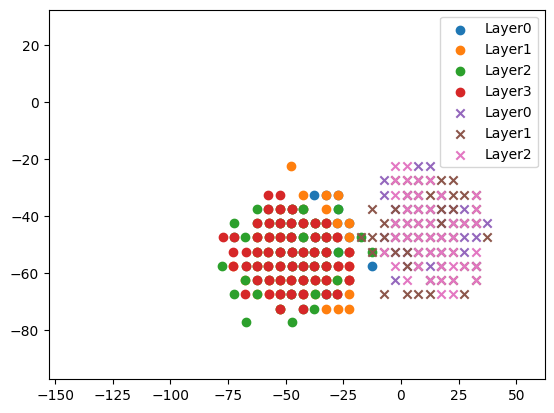

In [33]:
plot_multicluster(multi_depth_clusters[0], x_bounds, y_bounds, marker='o')
plot_multicluster(multi_depth_clusters[1], x_bounds, y_bounds, marker='x')

## 8. Measure Completeness and Homogeneity

In [34]:
testev

,E,ix,iy,iz,posx,posy,posz,NContributions,trueID1,trueID2,trueID3,trueID4,trueEfrac1,trueEfrac2,trueEfrac3,trueEfrac4
0,5.695240,51,44,1,-47.370159,-52.575001,387.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0
1,4.244005,51,44,2,-47.370159,-52.575001,397.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0
2,4.063787,51,45,2,-47.370159,-57.424999,393.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0
3,2.730911,44,45,2,-52.629841,-57.424999,405.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0
4,2.306139,50,44,1,-42.456718,-52.575001,377.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,0.001650,58,44,4,7.413440,-52.575001,437.279968,1,1,-1,-1,-1,1.0,0.0,0.0,0.0
567,0.001650,54,44,3,-22.456720,-52.575001,413.279968,1,1,-1,-1,-1,1.0,0.0,0.0,0.0
568,0.001650,55,48,1,-27.370159,-32.575001,373.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0
569,0.001650,62,47,1,37.370159,-47.424999,371.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0


In [128]:
# Get all true labels
labels_true = testev.trueID1.values
labels_pred = np.ones(len(testev))*-1

In [129]:
# Merge multiclusters into single dataframe with sorted index
multicluster_df = pd.concat(multi_depth_clusters).sort_index()

In [130]:
multicluster_df

,E,ix,iy,iz,posx,posy,posz,NContributions,trueID1,trueID2,trueID3,trueID4,trueEfrac1,trueEfrac2,trueEfrac3,trueEfrac4,dbscan_label,pred_label
0,5.695240,51,44,1,-47.370159,-52.575001,387.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0,0
1,4.244005,51,44,2,-47.370159,-52.575001,397.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0,0
2,4.063787,51,45,2,-47.370159,-57.424999,393.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0,0
3,2.730911,44,45,2,-52.629841,-57.424999,405.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0,0
4,2.306139,50,44,1,-42.456718,-52.575001,377.279999,1,0,-1,-1,-1,1.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0.001650,59,42,0,12.456720,-62.575001,363.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1
567,0.001650,54,44,3,-22.456720,-52.575001,413.279968,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,0,0
568,0.001650,55,48,1,-27.370159,-32.575001,373.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,0,0
569,0.001650,62,47,1,37.370159,-47.424999,371.279999,1,1,-1,-1,-1,1.0,0.0,0.0,0.0,1,1


In [131]:
# Set the predicted labels to be the multicluster labels by the index
labels_pred[multicluster_df.index] = multicluster_df.pred_label.values

In [132]:
# Get the homogeneity, completeness, v-measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels_true, labels_pred)
print(f'Homogeneity: {homogeneity}', f'Completeness: {completeness}', f'V-measure: {v_measure}')

Homogeneity: 0.5447361276284821 Completeness: 0.3385173629816251 V-measure: 0.417553147326346


In [130]:
# Set the predicted labels to be the multicluster labels by the index
labels_pred[multicluster_df.index] = multicluster_df.pred_label.values
# Where the predicted labels are -1, set them to be sequential from the max label
labels_pred[labels_pred == -1] = np.arange(np.max(labels_pred[labels_pred != -1])+1, np.max(labels_pred[labels_pred != -1])+1 + len(labels_pred[labels_pred == -1]))
# Get weights
weights = testev.E.values

In [132]:
# Get the homogeneity, completeness, v-measure
homogeneity_result, completeness_result, v_measure_result = homogeneity_completeness_v_measure(labels_true, labels_pred)
print(f'Homogeneity: {homogeneity_result}', f'Completeness: {completeness_result}', f'V-measure: {v_measure_result}')

Homogeneity: 0.8747617001420164 Completeness: 0.20552523262538497 V-measure: 0.3328478693209837


## Weighted V-Measure

In [123]:
from collections import Counter
import numpy as np
import scipy as sp
from sklearn.utils import check_array
from sklearn.metrics.cluster._supervised import check_clusterings
from sklearn.metrics import mutual_info_score

def weighted_homogeneity_completeness_v_measure(labels_true, labels_pred, beta=1.0, labels_weight=None):

    labels_true, labels_pred = check_clusterings(labels_true, labels_pred)

    if len(labels_true) == 0:
        return 1.0, 1.0, 1.0

    entropy_C_hat = weighted_entropy(labels_true, weights=labels_weight)
    entropy_K_hat = weighted_entropy(labels_pred, weights=labels_weight)

    contingency_hat = weighted_contingency_matrix(labels_true, labels_pred, sparse=True, weights=labels_weight)
    MI_hat = mutual_info_score(None, None, contingency=contingency_hat)

    homogeneity_hat = MI_hat / (entropy_C_hat) if entropy_C_hat else 1.0
    completeness_hat = MI_hat / (entropy_K_hat) if entropy_K_hat else 1.0

    if homogeneity_hat + completeness_hat == 0.0:
        v_measure_score_hat = 0.0
    else:
        v_measure_score_hat = (
            (1 + beta)
            * homogeneity_hat
            * completeness_hat
            / (beta * homogeneity_hat + completeness_hat)
        )

    return homogeneity_hat, completeness_hat, v_measure_score_hat

def weighted_entropy(labels, weights=None):
    """Calculates the entropy for a labeling."""
    if weights is None:
        weights = np.ones(len(labels))
    
    _, labels = np.unique(labels, return_inverse=True)

    pi_hat = np.bincount(labels, weights=weights)
    pi_hat = pi_hat[pi_hat > 0]
    pi_hat_sum = np.sum(pi_hat)

    return -np.sum((pi_hat / pi_hat_sum) * (np.log(pi_hat) - np.log(pi_hat_sum)))

def weighted_contingency_matrix(labels_true, labels_pred, sparse=False, weights=None):
    """Build a contengency matrix describing the relationship between labels.
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        Ground truth class labels to be used as a reference
    labels_pred : array, shape = [n_samples]
        Cluster labels to evaluate
    sparse : boolean, default False
        If True, return a sparse CSR continency matrix. If 'auto', the sparse
        matrix is returned for a dense input and vice-versa.
    weights : array, shape = [n_samples], optional
        Sample weights.
    """

    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]

    if weights is None:
        weights = np.ones(len(labels_true))

    # Make a float sparse array
    contingency = sp.sparse.coo_matrix(
        (weights, (class_idx, cluster_idx)),
        shape=(n_classes, n_clusters),
        dtype=np.float64
    )

    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
        return contingency

    return contingency.toarray() 

In [134]:
weights = testev.E.values

In [135]:
weighted_homogeneity, weighted_completeness, weighted_v_measure = weighted_homogeneity_completeness_v_measure(labels_true, labels_pred, labels_weight=weights)
print(f'Weighted Homogeneity: {weighted_homogeneity}', f'Weighted Completeness: {weighted_completeness}', f'Weighted V-measure: {weighted_v_measure}')

Weighted Homogeneity: 0.9553677124614924 Weighted Completeness: 0.7478720833536665 Weighted V-measure: 0.8389809153624802


## Hough Transform

In [ ]:
from hough_transform import hough_transform, normalize_points

First, plot these points

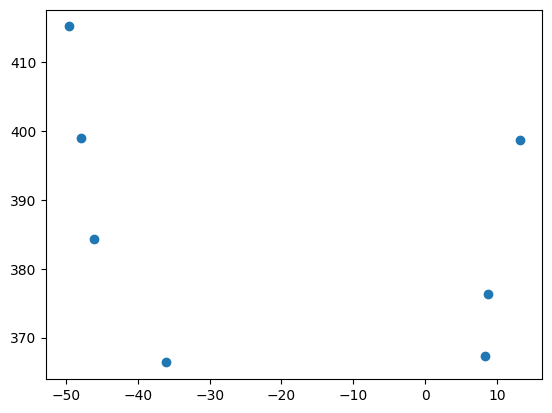

In [108]:
plt.scatter(cluster_pos_df.posx, cluster_pos_df.posz)

In [109]:
normalized_points = normalize_points(cluster_pos_array)

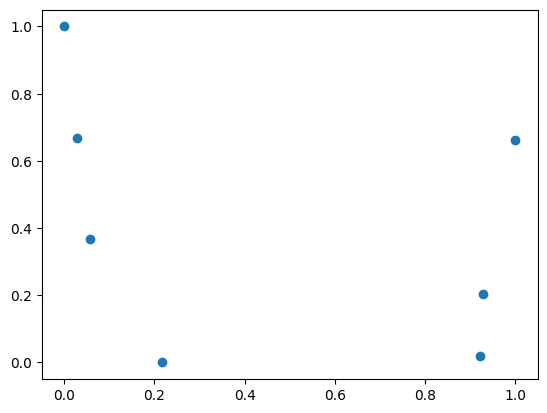

In [110]:
plt.scatter(normalized_points[:, 0], normalized_points[:, 1])

In [157]:
num_rhos = 20  # Number of rho values
num_thetas = 20  # Number of theta values
accumulator, rhos, thetas = hough_transform(cluster_pos_array, num_rhos, num_thetas)

<Axes: ylabel='Count'>

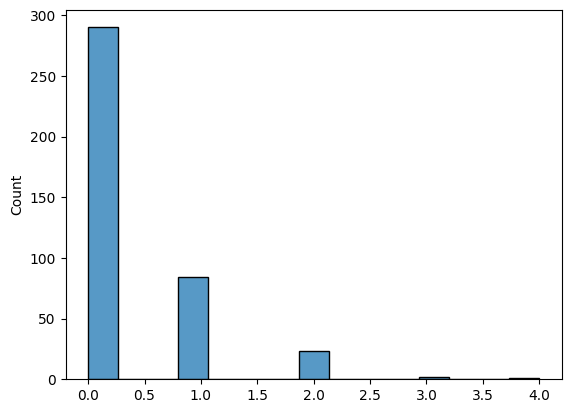

In [158]:
sns.histplot(accumulator.flatten())

In [159]:
# threshold = np.max(accumulator) * 0.5
max_indices = np.argwhere(accumulator >= 3)

In [160]:
detected_lines = []
for rho_idx, theta_idx in max_indices:
    rho = rhos[rho_idx]
    theta = thetas[theta_idx]
    detected_lines.append((rho, theta))

In [161]:
detected_lines

[(0.07443229148262431, 0.08267349088394194),
 (0.22329687444787272, 0.2480204726518258),
 (0.9676197892741154, -0.08267349088394194)]

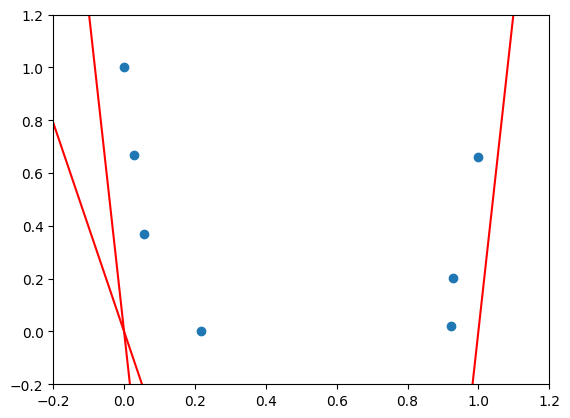

In [162]:
# Plot the original points and the detected lines
# plt.scatter(cluster_pos_array[:, 0], cluster_pos_array[:, 1])
# for rho, theta in detected_lines:
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a * rho
#     y0 = b * rho
#     x1 = int(x0 + 1000 * (-b))
#     y1 = int(y0 + 1000 * (a))
#     x2 = int(x0 - 1000 * (-b))
#     y2 = int(y0 - 1000 * (a))
#     plt.plot([x1, x2], [y1, y2], color='r', label='Detected Lines')
# plt.xlim(0, 100)
# plt.ylim(0, 100)
# plt.legend()
# plt.show()

# as above but with normalized points
plt.scatter(normalized_points[:, 0], normalized_points[:, 1])
for rho, theta in detected_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    plt.plot([x1, x2], [y1, y2], color='r', label='Detected Lines')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.show()

## Backup

In [ ]:
#This took me about 107 seconds on my macbook
diffs = []
for ev in range(1001):
    if(ev%100==0):
        print(ev)
    testev = eventContainer(ev, branches1)
    if(testev.tower_LFHCAL_N < 1):
        continue
    
    truthClusters = helperV2.makeTruthClusters(testev)
    
    listOfSCs = helperV2.runClusterizer(testev)
    combinedListOfSCs = helperV2.combineSuperClustersInLayer(listOfSCs)
    allClusters = helperV2.makeAllClusters(testev, combinedListOfSCs)
    layeredClusters = helperV2.makeLayeredClusters(allClusters)
    multiDepthClusters = helperV2.makeMultiDepthClusters(testev, layeredClusters)
    matchedClusters = helperV2.doClusterMatching(truthClusters, multiDepthClusters)
    
    tmpDiffs = helperV2.findMatchedDiffs(matchedClusters, truthClusters, multiDepthClusters)
    if(tmpDiffs is not None):
        diffs += tmpDiffs
    

0
100
200
300
400
500
600
700
800
900
1000


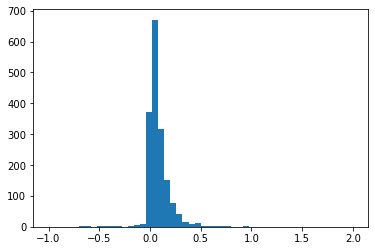

In [5]:
test = plt.hist(diffs, bins = 50, range=[-1,2])

In [6]:
#Running a single cluster
testev = eventContainer(60, branches1)
if(testev.tower_LFHCAL_N > 0):

    truthClusters = helperV2.makeTruthClusters(testev)

    listOfSCs = helperV2.runClusterizer(testev)
    combinedListOfSCs = helperV2.combineSuperClustersInLayer(listOfSCs)
    allClusters = helperV2.makeAllClusters(testev, combinedListOfSCs)
    layeredClusters = helperV2.makeLayeredClusters(allClusters)
    multiDepthClusters = helperV2.makeMultiDepthClusters(testev, layeredClusters)
    matchedClusters = helperV2.doClusterMatching(truthClusters, multiDepthClusters)

    tmpDiffs = helperV2.findMatchedDiffs(matchedClusters, truthClusters, multiDepthClusters)

38.03566100161947 -43.537318409570126 -53.14752116328707 397.4390348658607


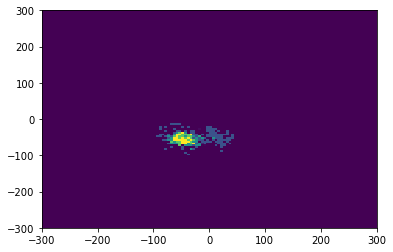

22.876600115397416 5.9147903830154815 -44.289463547276384 372.33547591985445


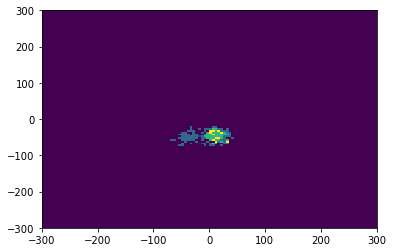

In [7]:
"""
Visualize two clusters.  In this instance, I know that event 60 has two nearby clusters
This is a bit of an illustration of why I might want to add in cluster pruning
to get rid of the "ghost" cluster components underneath the other clusters
In any case, you can compare the energy and position information with the next cell
and see that the reco clusters *are* pretty similar to the truth ones
"""
c=0
print(multiDepthClusters[c].energy,
      multiDepthClusters[c].posx,
      multiDepthClusters[c].posy,
      multiDepthClusters[c].posz)
test2 = plt.hist2d(list(testev.tower_LFHCAL_posx[multiDepthClusters[c].hitIndices]),
                   list(testev.tower_LFHCAL_posy[multiDepthClusters[c].hitIndices]),
                   weights=list(multiDepthClusters[c].hitFracs),
                   bins=[120,120], range=[[-300, 300], [-300, 300]])
plt.show()
c=1
print(multiDepthClusters[c].energy,
      multiDepthClusters[c].posx,
      multiDepthClusters[c].posy,
      multiDepthClusters[c].posz)
test3 = plt.hist2d(list(testev.tower_LFHCAL_posx[multiDepthClusters[c].hitIndices]),
                   list(testev.tower_LFHCAL_posy[multiDepthClusters[c].hitIndices]),
                   weights=list(multiDepthClusters[c].hitFracs),
                   bins=[120,120], range=[[-300, 300], [-300, 300]])

In [8]:
#See superEvent_Example for plotting truth clusters and plotting with energy weighting

In [10]:
ML_Cluster_Example = exampleMLBasedCluster(testev, multiDepthClusters[0].hitIndices, multiDepthClusters[0].hitFracs)
ML_Cluster_Example.calculateCluster()

38.03566100161947 -43.537318409570126 -53.14752116328707 397.4390348658607


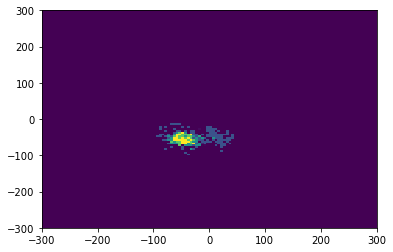

In [12]:
print(ML_Cluster_Example.energy, ML_Cluster_Example.posx, ML_Cluster_Example.posy, ML_Cluster_Example.posz)
test3 = plt.hist2d(list(testev.tower_LFHCAL_posx[ML_Cluster_Example.hitIndices]),
                   list(testev.tower_LFHCAL_posy[ML_Cluster_Example.hitIndices]),
                   weights=list(ML_Cluster_Example.hitFracs),
                   bins=[120,120], range=[[-300, 300], [-300, 300]])